# Lane Change Optimal Control using CVXPY  
This notebook computes an optimal lateral trajectory for a lane-change maneuver using:

- Double-integrator dynamics  
- Acceleration, jerk, and velocity constraints  
- Slack variables with penalties  
- Obstacle avoidance (time-window)  
- KKT dual-value inspection for one constraint  


## 1. Initialization
Importing core libraries:

'cvxpy' for optimization,

'numpy' for matrix operations,

'matplotlib' for visualization

& 'time' for solver_time analysis.

We also define a helper function to ensure user inputs (like speed limits) are valid.

In [129]:
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import time

In [130]:
#Helper function for clean interactive inputs
def get_input(prompt, default, cast=float, validator=None):
    while True:
        s = input(f"{prompt} [{default}]: ").strip()
        if s == "":
            return default
        try:
            val = cast(s)
            if validator is None or validator(val):
                return val
            print("Validation failed. Try again.")
        except:
            print("Invalid input. Try again.")


## 2. System Parameters and Constraints
Here we define the physical limits of the vehicle and the simulation environment.
* **Dynamics:** Time step ($dt$) and Horizon ($N$).
* **State:** Initial position/velocity and Target lane position.
* **Constraints:** Max acceleration ($u_{max}$), velocity ($v_{max}$), and jerk ($j_{max}$).
* **Penalties:** Slack weights to ensure the solver finds a solution even near physical limits.

In [131]:
dt = get_input("dt (s)", 0.1, float, lambda v: v > 0)
N = get_input("N (steps, integer >=1)", 50, int, lambda v: v >= 1)

init_y = get_input("init_y (m)", 0.0, float, lambda v: v >= 0)
init_vy = get_input("init_vy (m/s)", 0.0, float)
target_y = get_input("target_y (m)", 3.5, float, lambda v: v >= 0)
u_max = get_input("u_max (m/s^2)", 3.0, float, lambda v: v >= 0)
v_max = get_input("v_max (m/s)", 2.0, float, lambda v: v >= 0)
jerk_max = get_input("jerk_max (m/s^3)", 2.0, float, lambda v: v >= 0)
penalty_slack = get_input("penalty_slack", 1e6, float, lambda v: v > 0)
final_vy_target = get_input( f"final_vy_target (m/s) ≤ v_max({v_max})", 0.0, float, validator=lambda v: v <= v_max)

## 3. Obstacle Definition
We define the "Forbidden Window" in time. The start and end times are converted into discrete time steps ($k$). During these steps, the optimization solver is forced to keep the vehicle in the target lane to avoid a collision.

In [132]:
print("\nEnter obstacle times (in seconds).")
print("They will be converted into step indices using floor/ceil.\n")

while True:
    obs_t_start = get_input("Obstacle start time (s)", 2.5, float)
    obs_t_end   = get_input("Obstacle end   time (s)", 4.5, float)

    #convert time -> index
    k_obs_start = int(np.floor(obs_t_start / dt))
    k_obs_end   = int(np.ceil(obs_t_end / dt))
    
    #Now validate USING INDEX CONDITIONS
    if not (0 <= k_obs_start < k_obs_end <= N):
        print("\nERROR: Invalid obstacle time window.")
        print("After converting to indices:")
        print(f"  k_obs_start = {k_obs_start}")
        print(f"  k_obs_end   = {k_obs_end}")
        print("Required: 0 <= k_obs_start < k_obs_end <= N")
        print("Please re-enter.\n")
        continue

    break


Enter obstacle times (in seconds).
They will be converted into step indices using floor/ceil.



## 4. Mathematical Formulation (Convex QP)
We construct the problem for **CVXPY**:
1.  **State-Space Model:** $x_{k+1} = A x_k + B u_k$ (Double Integrator).
2.  **Objective:** Minimize Energy ($\sum u^2$) + Slack Penalties.
3.  **Constraints:**
    * **Dynamics:** Physics must be obeyed at every step.
    * **Safety:** Velocity, Acceleration, and Jerk must stay within limits.
    * **Obstacle:** Position $y_k \ge \text{Target Lane}$ during the obstacle window.

In [133]:
#Dynamics matrices
A = np.array([[1.0, dt],
              [0.0, 1.0]])
B = np.array([[0.5 * dt * dt],
              [dt]])

#Variables
u = cp.Variable((N, 1))
x = cp.Variable((2, N+1))
slack_u = cp.Variable((N, 1))
slack_v = cp.Variable((N+1, 1))
slack_final = cp.Variable((1, 1))

constraints = [x[:, 0] == np.array([init_y, init_vy])]
cost = 0

#NEW - KKT u_max constraint storage
kkt_constraint = []

#Build constraints
for k in range(N):

    constraints += [x[:, k+1] == A @ x[:, k] + B[:, 0] * u[k, 0]]

    #store u_max for KKT
    c_u = (cp.abs(u[k, 0]) <= u_max + slack_u[k, 0])
    constraints += [c_u]
    kkt_constraint.append(c_u)

    if k > 0:
        constraints += [cp.abs(u[k, 0] - u[k-1, 0]) <= jerk_max]

    cost += cp.sum_squares(u[k, 0])

#Velocity limit
for k in range(N+1):
    constraints += [cp.abs(x[1, k]) <= v_max + slack_v[k, 0]]

#Final target
constraints += [
    x[1, N] == final_vy_target,
    x[0, N] == target_y + slack_final[0, 0],
    slack_u >= 0,
    slack_v >= 0,
    slack_final >= 0
]

#Slack penalty
cost += penalty_slack * (
    cp.sum_squares(slack_u)
    + cp.sum_squares(slack_v)
    + cp.sum_squares(slack_final)
)

#Add obstacle constraints
obs_constraints = []
for k in range(k_obs_start, k_obs_end):
    c_obs = (x[0, k] >= target_y)
    constraints += [c_obs]
    obs_constraints.append(c_obs)


prob1 = cp.Problem(cp.Minimize(cost), constraints)
prob2 = cp.Problem(cp.Minimize(cost), constraints)

## 5. Solving with OSQP (Primary Solver)
We solve the problem using **OSQP**, a specialized solver for Quadratic Programs.
* **KKT Analysis:** After solving, we extract the **Dual Values (Lagrange Multipliers)** for the obstacle constraints. These values quantify the "energy cost" incurred by avoiding the obstacle.

In [134]:
#Store KKT indicators for both solvers
osqp_dual_indicator = []
osqp_primal_indicator = []
scs_dual_indicator = []
scs_primal_indicator = []
osqp_comp_slack = []
scs_comp_slack = []


#-------------- OSQP solve --------------
t0 = time.time()
prob1.solve(solver=cp.OSQP, verbose=False)
osqp_time = time.time() - t0

print("\nOSQP status:", prob1.status)
print(f"OSQP time: {osqp_time:.6f} sec")

x_osqp = np.array(x.value)
u_osqp = np.array(u.value).reshape(-1)

#KKT / complementary slackness check
if prob1.status in ["optimal", "optimal_inaccurate"]:
    for k_check in range(len(kkt_constraint)):
        c = kkt_constraint[k_check]

        dual = float(c.dual_value)
        osqp_dual_indicator.append(1 if dual >= 0 else -1)

        primal_gap = float(c.violation())
        osqp_primal_indicator.append(1 if primal_gap <= 0 else -1)

        comp = dual * primal_gap
        osqp_comp_slack.append(abs(comp))
        
    #printing first 10 complementary slackness values
    for i in range(10):
        print("Complementary slackness OSQP:", osqp_comp_slack[i])
    
    obs_duals = []
    #---Obstacle dual values (OSQP) ---
    for c in obs_constraints:
        dv = c.dual_value
        if dv is None:
            dv = 0
        obs_duals.append(abs(float(dv)))

    
else:
    print("Skipping KKT check; problem not optimal.")


OSQP status: optimal
OSQP time: 0.434169 sec
Complementary slackness OSQP: 0.0
Complementary slackness OSQP: 0.0
Complementary slackness OSQP: 0.0
Complementary slackness OSQP: 0.0
Complementary slackness OSQP: 0.0
Complementary slackness OSQP: 0.0
Complementary slackness OSQP: 0.0
Complementary slackness OSQP: 0.0
Complementary slackness OSQP: 0.0
Complementary slackness OSQP: 0.0


## 6. Solver Comparison (Methodology)
To validate our choice of solver, we resolve the identical problem using **SCS** (Splitting Conic Solver). We compare the execution time and convergence status to demonstrate why OSQP is preferred for this real-time control task.

In [135]:
#-------------- SCS solve --------------
t1 = time.time()
prob2.solve(solver=cp.SCS, verbose=False)
scs_time = time.time() - t1

print("\nSCS status:", prob2.status)
print(f"SCS time: {scs_time:.6f} sec")

x_scs = np.array(x.value)
u_scs = np.array(u.value).reshape(-1)

#KKT / complementary slackness check
if prob2.status in ["optimal", "optimal_inaccurate"]:
    for k_check in range(len(kkt_constraint)):
        c = kkt_constraint[k_check]

        dual = float(c.dual_value)
        scs_dual_indicator.append(1 if dual >= 0 else -1)

        primal_gap = float(c.violation())
        scs_primal_indicator.append(1 if primal_gap <= 0 else -1)

        comp = dual * primal_gap
        scs_comp_slack.append(abs(comp))
        
    #printing first 10 complementary slackness values
    for i in range(10):
        print("Complementary slackness SCS:", scs_comp_slack[i])
else:
    print("Skipping KKT check; problem not optimal.")

#Summary
print("\n===== Solver Comparison =====")
print(f"OSQP: {osqp_time:.6f} sec")
print(f"SCS : {scs_time:.6f} sec")
print("=============================")


SCS status: optimal
SCS time: 0.216443 sec
Complementary slackness SCS: 0.0
Complementary slackness SCS: 0.0
Complementary slackness SCS: 0.0
Complementary slackness SCS: 0.0
Complementary slackness SCS: 0.0
Complementary slackness SCS: 0.0
Complementary slackness SCS: 0.0
Complementary slackness SCS: 0.0
Complementary slackness SCS: 0.0
Complementary slackness SCS: 0.0

===== Solver Comparison =====
OSQP: 0.434169 sec
SCS : 0.216443 sec


## 7. Visualization and Analysis
We generate three key plots to interpret the results:
1.  **Solver Runtime:** A bar chart comparing OSQP vs. SCS speed.
2.  **KKT Feasibility:** Stem plots checking if Primal (physics) and Dual (optimality) conditions were met.
3.  **Optimal Trajectory:** A visual representation of the car's path, showing the computed swerve to avoid the red "Obstacle Zone" while minimizing control effort.

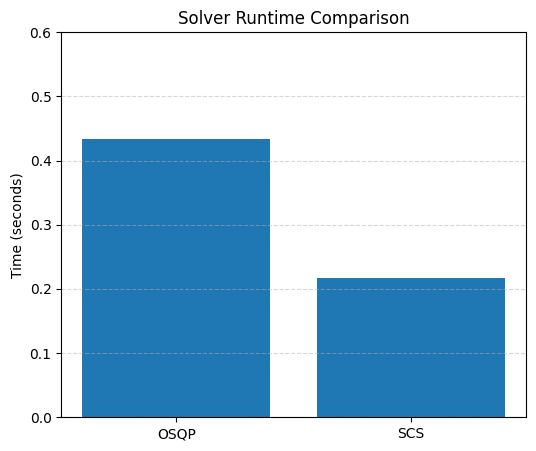

In [136]:
#-------------- Bar plot for solver times --------------
solvers = ["OSQP", "SCS"]
times = [osqp_time, scs_time]

plt.figure(figsize=(6, 5))
plt.bar(solvers, times)
plt.ylabel("Time (seconds)")
plt.title("Solver Runtime Comparison")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.ylim(0, 0.6
         
         
         
         )
plt.show()

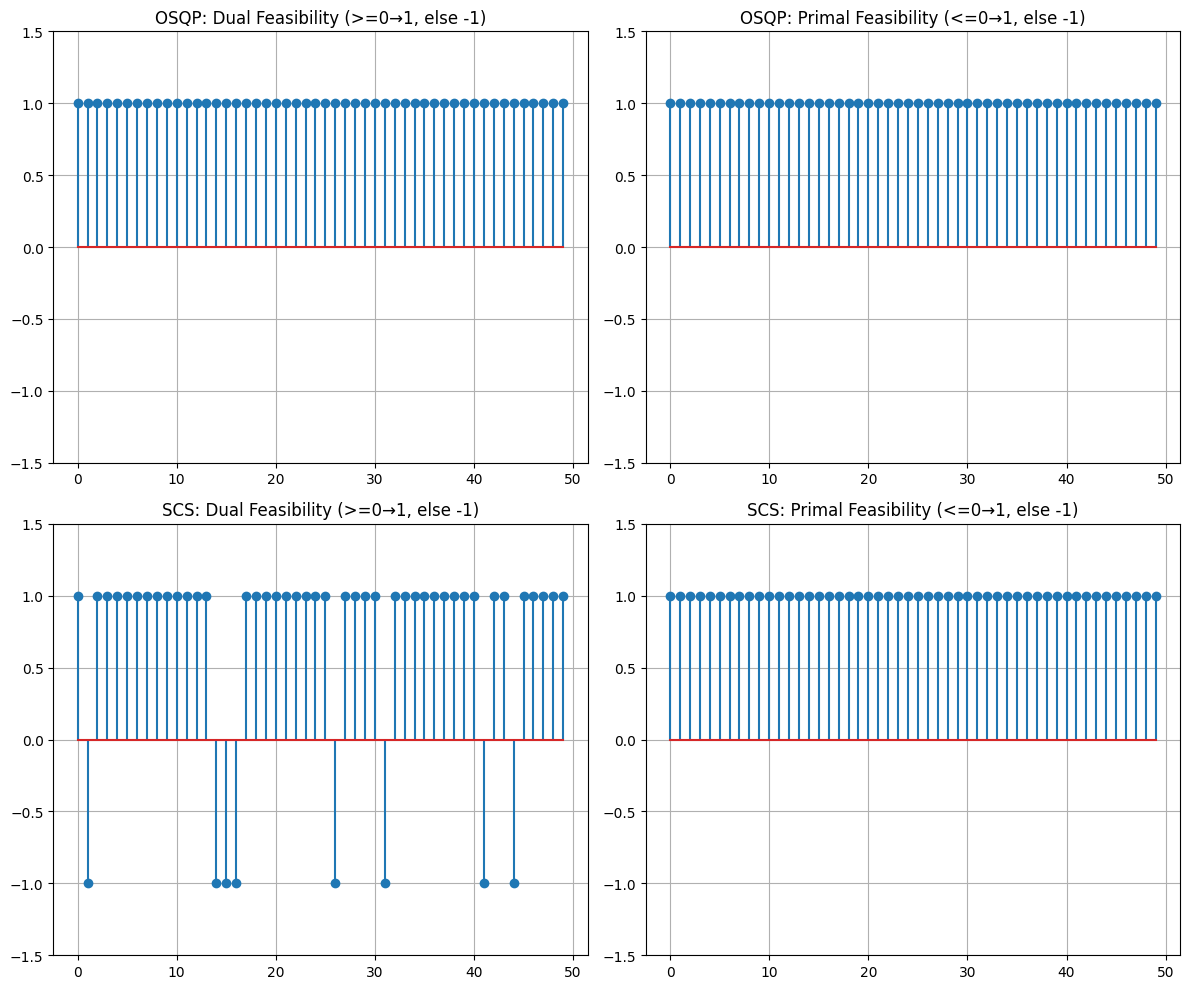

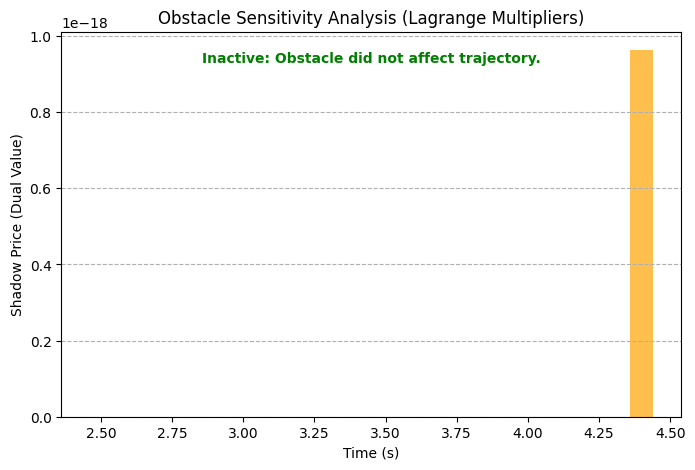

In [137]:

#--------- Plotting for kkt (dual , primal values gap)---------
if len(osqp_dual_indicator) > 0:
        plt.figure(figsize=(12, 10))

        ks = np.arange(len(kkt_constraint))

        plt.subplot(2, 2, 1)
        plt.stem(ks, osqp_dual_indicator)
        plt.title("OSQP: Dual Feasibility (>=0→1, else -1)")
        plt.ylim(-1.5, 1.5)
        plt.grid(True)

        plt.subplot(2, 2, 2)
        plt.stem(ks, osqp_primal_indicator)
        plt.title("OSQP: Primal Feasibility (<=0→1, else -1)")
        plt.ylim(-1.5, 1.5)
        plt.grid(True)

        plt.subplot(2, 2, 3)
        plt.stem(ks, scs_dual_indicator)
        plt.title("SCS: Dual Feasibility (>=0→1, else -1)")
        plt.ylim(-1.5, 1.5)
        plt.grid(True)

        plt.subplot(2, 2, 4)
        plt.stem(ks, scs_primal_indicator)
        plt.title("SCS: Primal Feasibility (<=0→1, else -1)")
        plt.ylim(-1.5, 1.5)
        plt.grid(True)

        plt.tight_layout()
        plt.show()

# OBSTACLE SENSITIVITY (Dual Values)
plt.figure(figsize=(8, 5))

obs_steps = np.arange(k_obs_start, k_obs_end)

plt.bar(obs_steps * dt, obs_duals, color='orange', alpha=0.7, width=0.08)
plt.title("Obstacle Sensitivity Analysis (Lagrange Multipliers)")
plt.xlabel("Time (s)")
plt.ylabel("Shadow Price (Dual Value)")
plt.grid(axis='y', linestyle='--')

max_dual = np.max(obs_duals) if len(obs_duals) > 0 else 0
if max_dual > 1e-4:
    plt.text(0.5, 0.92,
            "Active Constraint: Obstacle forced trajectory change.",
            ha='center', transform=plt.gca().transAxes,
            color='red', fontweight='bold')
else:
    plt.text(0.5, 0.92,
            "Inactive: Obstacle did not affect trajectory.",
            ha='center', transform=plt.gca().transAxes,
            color='green', fontweight='bold')

    plt.show()


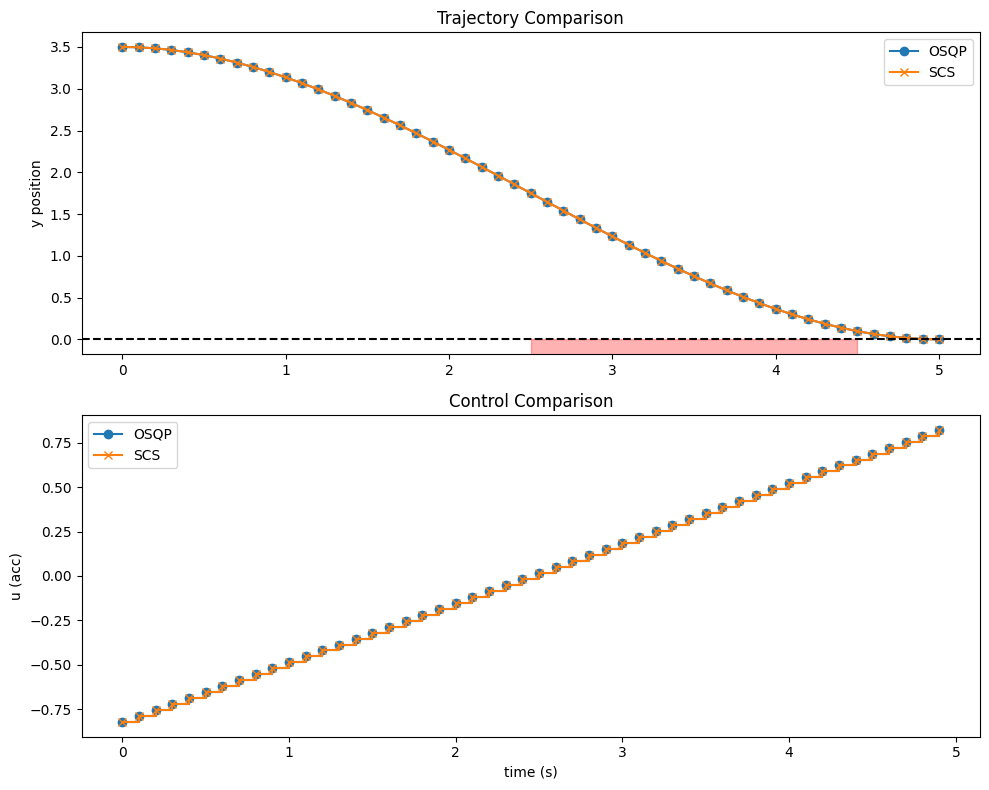

In [138]:


t = np.arange(N+1) * dt
fig, axs = plt.subplots(2, 1, figsize=(10, 8))

#Trajectory comparison
axs[0].plot(t, x_osqp[0, :], marker='o', label='OSQP')
axs[0].plot(t, x_scs[0, :], marker='x', label='SCS')
axs[0].axhline(target_y, linestyle='--', color='k')

rect = patches.Rectangle(
    (k_obs_start * dt, -10),
    (k_obs_end - k_obs_start) * dt,
    target_y + 10,
    color='red', alpha=0.3
)
axs[0].add_patch(rect)
axs[0].set_ylabel("y position")
axs[0].legend()
axs[0].set_title("Trajectory Comparison")

#Control comparison
axs[1].step(t[:-1], u_osqp, where='post', marker='o', label='OSQP')
axs[1].step(t[:-1], u_scs,  where='post', marker='x', label='SCS')
axs[1].set_xlabel("time (s)")
axs[1].set_ylabel("u (acc)")
axs[1].legend()
axs[1].set_title("Control Comparison")

plt.tight_layout()
plt.show()